In [1]:
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
from scipy.signal import welch
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
data_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/data'

Label Information

In [3]:
sampling_frequency = 100

In [4]:
label_list = ['rotate_next', 'rotate_prev', 'like', 'stop', 'other']

In [5]:
label_to_idx = {
    'rotate_next': 0,
    'rotate_prev': 1,
    'like': 2,
    'stop': 3,
    'other': 4
}

In [6]:
idx_to_label = {
    0: 'rotate_next',
    1: 'rotate_prev',
    2: 'like',
    3: 'stop',
    4: 'other'
}

Functions for Feature Extraction

In [7]:
feature_list = ['mean', 'std', 'energy', 'max_val', 'min_val', 'min_max_range', 
                'median_above_mean', 'iqr', 'skewness', 
                'mean_psd', 'std_psd', 'max_psd', 'median_psd', 'min_psd', 'entropy_psd']

In [8]:
def mean(signal):
    return np.mean(signal)

In [9]:
def std(signal):
    return np.std(signal)

In [10]:
def energy(signal):
    return np.sum(np.square(signal)) / len(signal)

In [11]:
def max_val(signal):
    return np.max(signal)

In [12]:
def min_val(signal):
    return np.min(signal)

In [13]:
def min_max_range(signal):
    return np.max(signal) - np.min(signal)

In [14]:
def median_above_mean(signal):
    mean_val = np.mean(signal)
    above_mean = signal[signal > mean_val]
    if len(above_mean) > 0:
        return np.median(above_mean)
    else:
        return 0

In [15]:
def interquartile_range(signal):
    return np.percentile(signal, 75) - np.percentile(signal, 25)

In [16]:
def skewness(signal):
    return stats.skew(signal)

In [17]:
def psd_features(signal, fs):  # fs: sampling frequency
    freqs, psd = welch(signal, fs=fs, nperseg=min(len(signal), 256))
    mean_psd = np.mean(psd)
    std_psd = np.std(psd)
    max_psd = np.max(psd)
    min_psd = np.min(psd)
    median_psd = np.median(psd)
    
    # Normalize for entropy calculation
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else np.ones_like(psd) / len(psd)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # avoid log(0)
    
    return {
        'mean_psd': mean_psd,
        'std_psd': std_psd,
        'max_psd': max_psd,
        'min_psd': min_psd,
        'median_psd': median_psd,
        'entropy_psd': entropy
    }

In [18]:
def extract_features_column(signal, column_name, fs):
    features = {}
    features[column_name + '_mean'] = mean(signal)
    features[column_name + '_std'] = std(signal)
    features[column_name + '_energy'] = energy(signal)
    features[column_name + '_max_val'] = max_val(signal)
    features[column_name + '_min_val'] = min_val(signal)
    features[column_name + '_min_max_range'] = min_max_range(signal)
    features[column_name + '_median_above_mean'] = median_above_mean(signal)
    features[column_name + '_iqr'] = interquartile_range(signal)
    features[column_name + '_skewness'] = skewness(signal)

    signal_psd_features = psd_features(signal, fs)
    for key, value in signal_psd_features.items():
        features[column_name + '_' + key] = value
    
    return features

In [19]:
def extract_features(df, fs):
    combined_features = {}
    for column_name in df.columns:
        # print(f"column name: {column_name}")
        # print(df[column_name])
        column_data = df[column_name].to_numpy()
        # print(column_data.shape)
        column_features = extract_features_column(column_data, column_name, fs)
        combined_features.update(column_features)
    return combined_features


***Processing Test Data***

In [20]:
X = []
y = []

total_files = 0

for label in label_list:
    label_path = os.path.join(data_path, label)
    csv_folder = os.path.join(label_path, 'csv')
    # print(csv_folder)
    for file in os.listdir(csv_folder):
        csv_path = os.path.join(csv_folder, file)
        if not csv_path.endswith('.csv'):  # Only process .csv files
            continue
        total_files += 1
        df = pd.read_csv(csv_path)
        df = df.rename(columns={' pitch': 'pitch'})
        df = df[['accel_x', 'accel_y', 'accel_z', 'rotation_x', 'rotation_y', 'rotation_z', 'pitch', 'roll', 'yaw']]
        numpy_df = df.to_numpy()
        # print(numpy_df.shape)
        # print(df.head())
        features = extract_features(df, sampling_frequency)
        # print(len(features))
        X.append(np.array(list(features.values())))
        y.append(label_to_idx[label])

Running feature extraction one file, just to show what one row in test data X looks like

In [21]:
example_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/data/rotate_next/csv/rotate_next_1.csv'
example_df = pd.read_csv(example_path)
example_df = example_df.rename(columns={' pitch': 'pitch'})
example_df = example_df[['accel_x', 'accel_y', 'accel_z', 'rotation_x', 'rotation_y', 'rotation_z', 'pitch', 'roll', 'yaw']]
example_numpy_df = example_df.to_numpy()
example_features = extract_features(example_df, sampling_frequency)

In [22]:
print(example_df.head())

    accel_x   accel_y   accel_z  rotation_x  rotation_y  rotation_z     pitch  \
0  0.008994 -0.004327  0.014573   -0.018462   -0.009059    0.002848  0.061630   
1  0.009387  0.000875  0.011251   -0.015257   -0.010795    0.001079  0.061460   
2  0.009782  0.003968  0.009173   -0.011441   -0.001200    0.005005  0.061334   
3  0.006795  0.002524  0.007669   -0.009073   -0.003970    0.004009  0.061247   
4  0.004537  0.003886  0.007919   -0.008531    0.003799   -0.000902  0.061160   

       roll       yaw  
0  0.093308 -0.002878  
1  0.093204 -0.002843  
2  0.093159 -0.002814  
3  0.093138 -0.002763  
4  0.093138 -0.002749  


In [23]:
print(example_features)

{'accel_x_mean': -0.007915202821028668, 'accel_x_std': 0.054905288282534326, 'accel_x_energy': 0.0030772411170862215, 'accel_x_max_val': 0.1557944416999817, 'accel_x_min_val': -0.300251841545105, 'accel_x_min_max_range': 0.45604628324508667, 'accel_x_median_above_mean': 0.00454863486811515, 'accel_x_iqr': 0.025558864697813898, 'accel_x_skewness': -1.6807061679827917, 'accel_x_mean_psd': 9.539751699533137e-05, 'accel_x_std_psd': 0.0002545135486886539, 'accel_x_max_psd': 0.001652299314774609, 'accel_x_min_psd': 1.3437118983779254e-08, 'accel_x_median_psd': 6.217549424435451e-06, 'accel_x_entropy_psd': 4.756074371394116, 'accel_y_mean': 0.017957578765159864, 'accel_y_std': 0.17919877183876684, 'accel_y_energy': 0.032434674463629326, 'accel_y_max_val': 1.0747255086898804, 'accel_y_min_val': -0.6119800209999084, 'accel_y_min_max_range': 1.6867055296897888, 'accel_y_median_above_mean': 0.06151790171861645, 'accel_y_iqr': 0.02584247663617125, 'accel_y_skewness': 2.618018149281359, 'accel_y_me

In [24]:
X = np.array(X)
y = np.array(y)

In [25]:
print(X.shape)
print(y.shape)


(100, 135)
(100,)


***Random Forest***

In [26]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [28]:
scaler_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/scaler/scaler.joblib'
joblib.dump(scaler, scaler_path)

['/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/scaler/scaler.joblib']

In [29]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [30]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, validation=False):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, accuracy

In [31]:
random_forest, accuracy = train_and_evaluate_model(random_forest, train_X, test_X, train_y, test_y)
print("model: ", random_forest)
print("model accuracy: ", accuracy)

model:  RandomForestClassifier(random_state=42)
model accuracy:  1.0


In [32]:
model_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/models'
random_forest_path = os.path.join(model_path, 'random_forest.joblib')
joblib.dump(random_forest, random_forest_path)

['/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/models/random_forest.joblib']

In [33]:
holdout_data_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/holdout_data'

In [34]:
holdout_X = []
holdout_y = []
total_holdout_files = 0

for label in label_list:
    holdout_label_path = os.path.join(holdout_data_path, label)
    
    for holdout_csv in os.listdir(holdout_label_path):
        csv_path = os.path.join(holdout_label_path, holdout_csv)
        if not csv_path.endswith('.csv'):  # Only process .csv files
            continue
        total_holdout_files += 1
        df = pd.read_csv(csv_path)
        df = df.rename(columns={' pitch': 'pitch'})
        df = df[['accel_x', 'accel_y', 'accel_z', 'rotation_x', 'rotation_y', 'rotation_z', 'pitch', 'roll', 'yaw']]
        numpy_df = df.to_numpy()
        # print(numpy_df.shape)
        # print(df.head())
        features = extract_features(df, sampling_frequency)
        # print(len(features))
        holdout_X.append(np.array(list(features.values())))
        holdout_y.append(label_to_idx[label])

In [35]:
holdout_X = np.array(holdout_X)
holdout_y = np.array(holdout_y)

In [36]:
print(holdout_X.shape)
print(holdout_y.shape)

(25, 135)
(25,)


In [37]:
holdout_X = scaler.transform(holdout_X)

In [38]:
y_pred_rf = random_forest.predict(holdout_X)
holdout_accuracy_rf = accuracy_score(holdout_y, y_pred_rf)
holdout_accuracy_rf

0.8

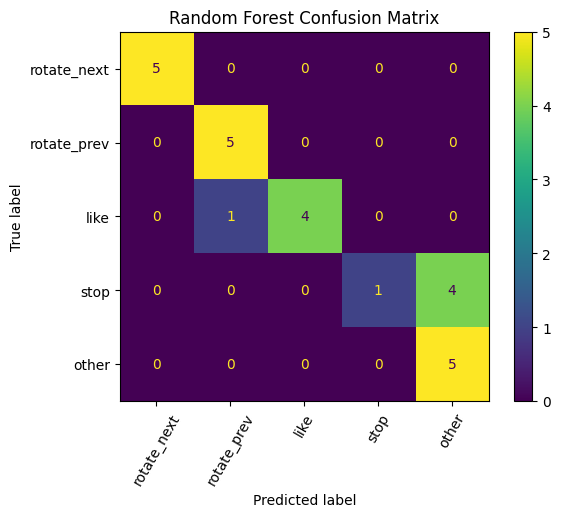

In [39]:
rf_confusion_matrix = confusion_matrix(holdout_y, y_pred_rf, labels=[0, 1, 2, 3, 4])
rf_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_confusion_matrix, display_labels = label_list)
rf_cm_display.plot()
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=60)
plt.show()

Neural Network (Linear Layers)

In [40]:
import torch.nn as nn

input_size = 9 * 15 # 9 sensors * 15 features
output_size = 5  # 5 gesture classes

model = nn.Sequential(
    # Layer 1: Input -> Hidden
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    
    # Layer 2: Hidden -> Hidden
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    
    # Layer 3: Hidden -> Hidden
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.3),
    
    # Layer 4: Hidden -> Hidden
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Dropout(0.3),
    
    # Layer 5: Hidden -> Output
    nn.Linear(32, output_size)
)

In [41]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.long)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.long)

In [42]:
learning_rate = 0.001
num_epochs = 25
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
train_dataset = torch.utils.data.TensorDataset(train_X_tensor, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [44]:
# 5. Training loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Evaluation on test set
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_X_tensor)
        test_loss = criterion(test_outputs, test_y_tensor)
        _, predicted = torch.max(test_outputs.data, 1)
        test_accuracy = 100 * ((predicted == test_y_tensor).sum().item() / test_y_tensor.size(0))
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Train Acc: {epoch_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, '
              f'Test Acc: {test_accuracy:.2f}%')

Epoch [5/25], Train Loss: 0.7779, Train Acc: 83.75%, Test Loss: 1.2147, Test Acc: 85.00%
Epoch [10/25], Train Loss: 0.4924, Train Acc: 93.75%, Test Loss: 0.6095, Test Acc: 90.00%
Epoch [15/25], Train Loss: 0.4018, Train Acc: 100.00%, Test Loss: 0.3512, Test Acc: 100.00%
Epoch [20/25], Train Loss: 0.3494, Train Acc: 95.00%, Test Loss: 0.2445, Test Acc: 100.00%
Epoch [25/25], Train Loss: 0.2659, Train Acc: 97.50%, Test Loss: 0.1888, Test Acc: 100.00%


In [45]:
model_path = '/Users/pranavxiyer/Documents/northwestern/classes/first/spring/machine learning and sensing/MotionMusicPlayer/models'
nn_name = 'neural_net.pth'
nn_path = os.path.join(model_path, nn_name)
torch.save(model.state_dict(), nn_path)

In [46]:
holdout_X_tensor = torch.tensor(holdout_X, dtype=torch.float32)
holdout_y_tensor = torch.tensor(holdout_y, dtype=torch.long)

In [47]:
# Evaluate on holdout data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    holdout_outputs = model(holdout_X_tensor)
    holdout_loss = criterion(holdout_outputs, holdout_y_tensor)
    _, predicted = torch.max(holdout_outputs.data, 1)
    holdout_accuracy = 100 * ((predicted == holdout_y_tensor).sum().item() / holdout_y_tensor.size(0))
    
    # Print results
    print(f'Holdout Loss: {holdout_loss:.4f}')
    print(f'Holdout Accuracy: {holdout_accuracy:.2f}%')

Holdout Loss: 0.8494
Holdout Accuracy: 92.00%


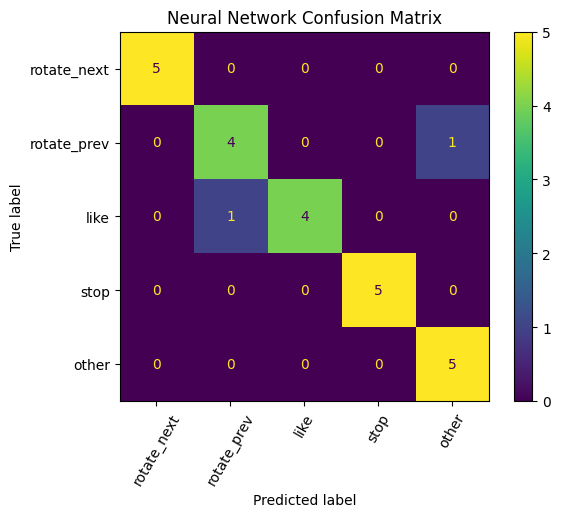

In [48]:
nn_confusion_matrix = confusion_matrix(holdout_y, predicted, labels=[0, 1, 2, 3, 4])
nn_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = nn_confusion_matrix, display_labels = label_list)
nn_cm_display.plot()
plt.title('Neural Network Confusion Matrix')
plt.xticks(rotation=60)
plt.show()